In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.791523 -0.367426  0.015682  1.381771  2.153509  0.208878 -0.370136   
  1   0.155523 -0.316494 -0.016472  0.753455 -0.127212  0.309816 -1.038531   
  2   0.246031 -0.379369 -0.568874  0.511223  0.088424  0.238650 -0.154836   
  3  -0.286645  1.169557 -0.206789 -0.186315  1.155191 -0.265393  0.057767   
  4  -0.293586  0.227059 -0.528720 -0.157645 -0.341920  0.177560 -0.011869   
  5  -0.692291 -0.969132 -0.349195 -0.272000  0.446828  1.017578 -1.178219   
  6  -0.564769  0.236509  0.262339  0.487715 -0.257693 -0.114013 -0.216526   
  7   0.374543  0.283763  0.292966  1.002547 -0.037690  0.205082 -1.016076   
  8  -0.264852  0.055110  0.339193  0.433151  0.758347  0.207135 -0.341219   
  9   1.272505  0.147346 -0.099590  0.824078  0.498484  0.211780  0.089945   
  10  0.392828  0.839114  0.486088 -0.559523 -0.025538 -0.137662 -0.404085   
  11  0.635626 -0.244995  0.907848  0.005445 -0.000456 -0.352646  0.079668   
  12  0.075916  0.098416 -0.122826  0.970707  0.614416  0.444664 -0.447658   
  13  0.730349  0.631394 -1.156836  0.605761  1.037098  0.357293  0.285669   
  14 -1.043550 -0.068159 -0.883478 -0.291111 -0.036263 -1.227493 -0.705831   
  15 -1.011057  0.160058 -0.403026 -0.995324  0.088099  0.133945  0.295874   
  16  0.189585 -0.188319  0.956151  1.197586  0.408218 -0.044167 -1.102456   
  17  0.239665  1.221176  0.205111  0.398090  0.935194  0.932922 -0.937053   
  18  0.381578  0.535250  0.290250 -0.094675 -0.342887  0.077991  0.334445   
  19 -0.444181  0.393786  0.958248  0.894197  0.249489  0.414777  0.906900   
  20  0.006324 -0.314779 -1.001291  0.441788  1.022548  0.838203 -0.296366   
  21 -0.386555 -0.429604 -0.182783  0.199745  0.274155 -1.063423 -1.373769   
  22  0.052855  0.652980  0.592275  0.302282  0.497951  0.941224 -0.055403   
  23  0.025620  0.013475 -1.201862 -0.438220 -0.289193  0.653428 -0.542691   
  24  0.134196 -0.617318 -0.093675  0.172578  0.195710  0.056270  0.787713   
1 0  -0.410226 -0.157178  0.392497 -0.769419 -0.555895 -0.197462 -0.321903   
  1  -0.159100  0.182056  0.481992  1.082032 -0.816191 -0.039246  0.489018   
  2  -0.161632  0.047008  0.667977  0.698399 -0.644769 -1.411864 -0.514497   
  3  -0.408511  0.299858  0.311939 -0.168279 -0.002056 -0.648628 -0.408537   
  4   0.684862  0.083682  0.116482  0.210110 -0.399138 -0.448221 -1.382088   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.668852 -0.465226  0.328352  ... -0.737776 -0.107991  1.460905   
  1  -0.632864 -0.698195  0.404636  ...  0.318855  0.164892 -1.042837   
  2  -0.259166 -0.660316  0.211884  ...  0.712902  1.347640  0.463205   
  3  -0.288064 -0.755808 -0.237552  ...  0.423904  0.522771  0.461758   
  4   1.176510  0.544820  0.239760  ... -0.010711  0.938027  0.266761   
  5  -0.760713 -0.695106 -0.716876  ... -0.253164 -0.215800  0.367385   
  6  -0.154955 -0.717191  0.155435  ... -0.079903  0.107999 -0.233006   
  7  -0.204944  0.086924 -0.288758  ...  0.638795 -0.098367  0.618288   
  8  -1.058869  0.066857 -0.221761  ... -0.054296  0.663282  0.847080   
  9  -0.776066 -0.283604  0.412427  ...  0.518846  0.518372  0.932864   
  10  0.654555  0.237031  0.375448  ...  0.200676 -0.115253 -0.392978   
  11 -0.206607  0.072849  0.618278  ...  0.090004  0.058991  0.116387   
  12 -0.584877  0.540106 -0.144282  ...  0.145372  0.750818 -0.113614   
  13  0.555862 -0.045269 -0.138607  ... -0.413615  0.602734 -0.314402   
  14 -0.192606 -0.683434  0.806423  ...  0.870095  0.198714  0.768000   
  15 -1.106842 -1.348258 -0.004066  ...  0.377588  1.542221  0.587895   
  16 -0.904906 -1.170845  0.567694  ... -0.893573 -0.020138 -0.102625   
  17 -1.007394 -1.288563 -0.361455  ... -0.729468  1.436940  0.810496   
  18 -0.718859 -0.614086  0.074108  ...  0.154511  0.662794  0.369680   
  19  0.285264 -0.546378 -0.525863  ...  0.783342 -0.483643 -0.368494   
  20 -1.047559 -0.727477  0.942896  ... -0.248291  0.524707 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %   97.5 %
D  1.072113  0.042474  25.241553  1.402244e-140  0.988865  1.15536


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



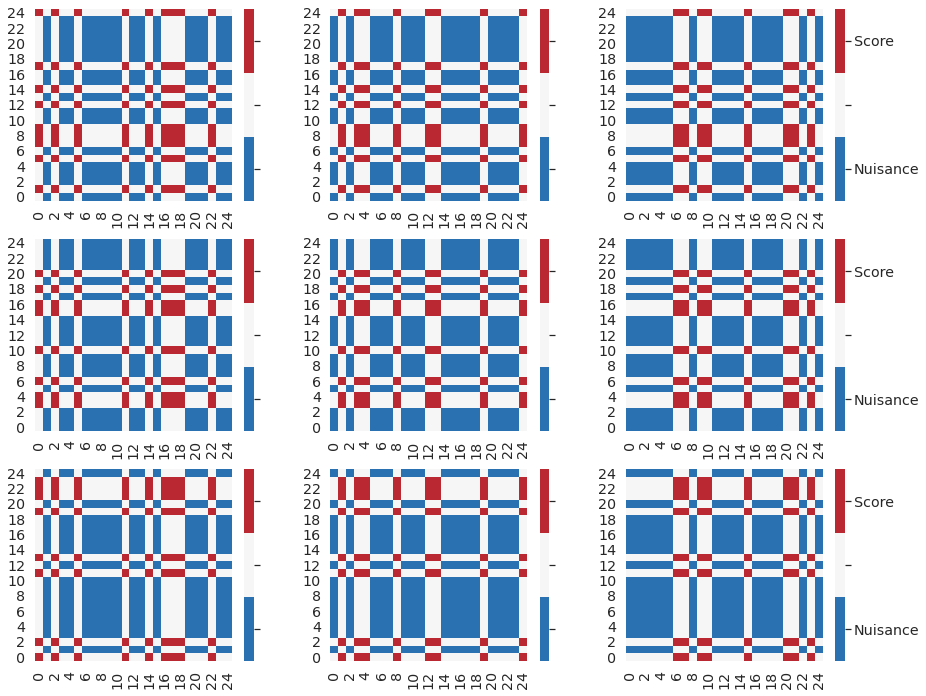

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



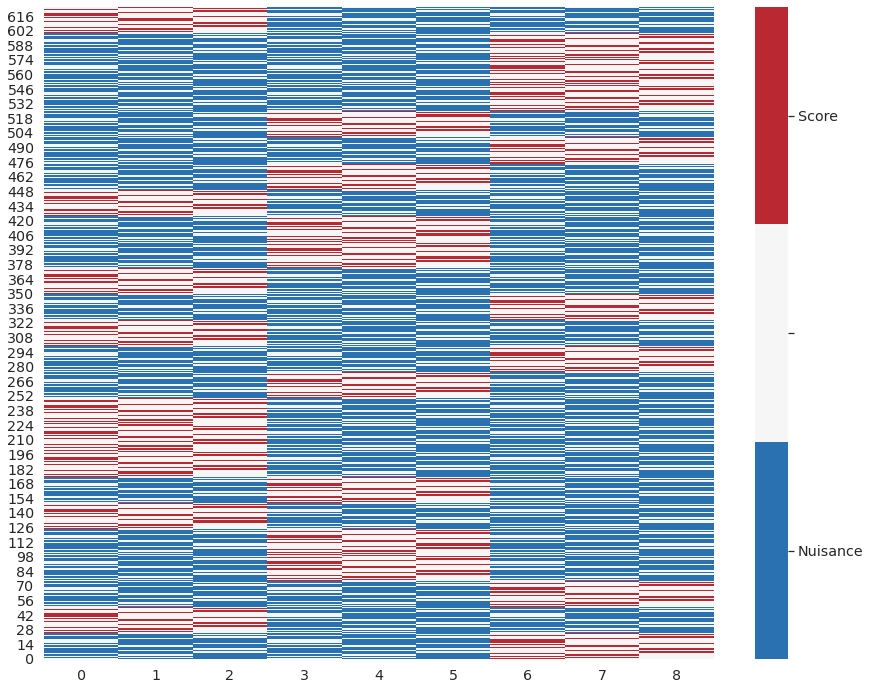

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])